<a href="https://colab.research.google.com/github/jcdevaney/metricData/blob/main/metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries and Data

In [ ]:
!pip install jams
!pip install libfmp
#!pip install wget
import numpy as np, os, scipy
import pandas as pd
from matplotlib import pyplot as plt
import librosa
import mir_eval
#import urllib.request as urll
#import wget
#from sortedcontainers import SortedKeyList

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 60.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 54.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 5.1 MB/s eta 0:00:00
  Created wheel for music21: filename=music21-5.7.2-py3-none-any.whl size=22024625 sha256=b2e8060ee04b3bde3ce27cb9d12329e15aed07293edc754fcdbf776f4e4849b1
  Stored in directory: /root/.cache/pip/wheels/d1/eb/81/e858063b266b06812875dce9e1c04e66bbca397d5bf19fb1ce
  Created wheel for pretty-midi: filename=pretty_midi-0.2.

## Load ACE Estimates

In [ ]:
!git clone https://github.com/jcdevaney/metricData.git
df_all_songs_ACE = pd.read_csv('/content/metricData/aceEstimates.csv')
df_all_songs_ACE = df_all_songs_ACE.iloc[:,1:4]

Cloning into 'metricData'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), 1.64 MiB | 2.78 MiB/s, done.


# Define Metrics

In [ ]:
from libfmp.c3 import normalize_feature_sequence

def cossim(vec1, vec2, threshold=0.001):
    vec1_norm = normalize_feature_sequence(vec1, norm='2', threshold=threshold)
    vec2_norm = normalize_feature_sequence(vec2, norm='2', threshold=threshold)
    cosine_sim = np.sum(np.multiply(vec1_norm, vec2_norm))/vec2_norm.shape[1]
    return cosine_sim

In [ ]:
# calculates chord metric on aboslute PC bitmap
# assumes numpy array as input
def predictionsInsertionsBM(estimateBM, referenceBM):

    estimate=set(estimateBM.nonzero()[0])
    reference=set(referenceBM.nonzero()[0])

    # C is the number of predicted notes in the estimate that occur in the reference (ground truth)
    C = len(estimate.intersection(reference))

    # I is the number of insertions (extra predicted notes) in the estimate that are not present in
    # the reference (ground truth)
    I = len(estimate.difference(reference))

    # accuracy measurement for each chord estimate, scaled between 0 and 1
    A = (C - I + len(reference)) / (2*len(reference))

    return A

# predictionsInsertionsBM(absolute_pcs1,absolute_pcs2)

In [ ]:
# symmetrized version of above measure

# def predictionsInsertionsSymmetric(label1BM, label2BM):

#     label1=set(label1BM.nonzero()[0])
#     label2=set(label2BM.nonzero()[0])

#     if (len(label1)==0) & (len(label2)==0):
#         A = 1
#     elif len(label1)==0:
#         A = predictionsInsertionsBM(label1BM, label2BM)
#     elif len(label2)==0:
#         A = predictionsInsertionsBM(label2BM, label1BM)
#     else:
#         A = (predictionsInsertionsBM(label1BM, label2BM) + predictionsInsertionsBM(label2BM, label1BM))/2

#     return A

def predictionsInsertionsSymmetric(estimateBM, referenceBM):
    estimate=set(estimateBM.nonzero()[0])
    reference=set(referenceBM.nonzero()[0])
    le = len(estimate)
    lr = len(reference)

    # C is the number of predicted notes in the estimate that occur in the reference (ground truth)
    C = len(estimate.intersection(reference))

    # I is the number of insertions (extra predicted notes) in the estimate that are not present in
    # the reference (ground truth)
    I = max(len(estimate.difference(reference)), len(reference.difference(estimate)))

    maxlength = max(le, lr)

    if maxlength==0:
        A = 1

    else:
        # accuracy measurement for each chord estimate, scaled between 0 and 1
        A = (C - I + maxlength) / (2*maxlength)
        # A = (C - I + len(reference)) / (2*len(reference))

    return A

# ACE Calculations

In [ ]:
# Calculate Pairwise Stats

# Print all pairs of annotations that disagree in the root (ignoring 'N')

from itertools import combinations

def pairwiseStats(df_all_songs_ACE, algorithm):
      previousstring = ''
      counter = 0
      allpairs = 0
      pairwise_stats = np.zeros((0, 5))   # statistics: #pcs1, #pcs2, #pcsshared, cs, idm

      for index, row in df_all_songs_ACE.iterrows():

              allpairs += 1
              exec("label1 = row['Reference']")
              exec("label2 = row[algorithm]")
              root1, shorthand1, scaledeg1, bass1 = mir_eval.chord.split(label1)
              root2, shorthand2, scaledeg2, bass2 = mir_eval.chord.split(label2)

              rootlist_clean = [root1, root2]
              while 'N' in rootlist_clean: rootlist_clean.remove('N')
              rootlist_clean = [mir_eval.chord.pitch_class_to_semitone(r) for r in rootlist_clean]

              if (len(rootlist_clean)>1):

                  if (rootlist_clean[0]!=rootlist_clean[1]):
                      print(rootlist_clean)
                      counter+=1
                      comparestring = root1+':'+shorthand1+' - '+root2+':'+shorthand2

                      rootnum1, bitmap1, bassnum1 = mir_eval.chord.encode(label1, reduce_extended_chords=False, strict_bass_intervals=False)
                      absolute_pcs1 = mir_eval.chord.rotate_bitmap_to_root(bitmap1, rootnum1)
                      rootnum2, bitmap2, bassnum2 = mir_eval.chord.encode(label2, reduce_extended_chords=False, strict_bass_intervals=False)
                      absolute_pcs2 = mir_eval.chord.rotate_bitmap_to_root(bitmap2, rootnum2)

                      # cosine similarity measure
                      cs12 = cossim(np.expand_dims(absolute_pcs1, axis=-1), np.expand_dims(absolute_pcs2, axis=-1))

                      # insertion-deletion measure (Johanna)
                      idm12 = predictionsInsertionsSymmetric(absolute_pcs1, absolute_pcs2)

                      # if cs12>0.95:
                      #print('{:<20}'.format(comparestring) + '   |  CS: ' + '{:.3f}'.format(cs12) + '  | IDM: ' + '{:.3f}'.format(idm12))

                      pclist1 = set(absolute_pcs1.nonzero()[0])
                      pclist2 = set(absolute_pcs2.nonzero()[0])
                      pclistjoint = pclist1.intersection(pclist2)

                      num_pcs1 = len(pclist1)
                      num_pcs2 = len(pclist2)
                      num_pcs_shared = len(pclistjoint)
                      curr_stats = np.array([[num_pcs1, num_pcs2, num_pcs_shared, cs12, idm12]])
                      pairwise_stats = np.concatenate((pairwise_stats, curr_stats), axis=0)

                      previousstring = comparestring

      return pairwise_stats

def relative_overlapping_plot(pairwise_stats):
  # print(pairwise_stats.shape)
  # print(pairwise_stats)

  #plt.figure(figsize=(6.5,3.5))
  plt.figure(figsize=(4,2))
  plt.plot(100*pairwise_stats[:, 2]/(0.5*(pairwise_stats[:, 0]+pairwise_stats[:, 1])), pairwise_stats[:, 3], 'b+', markeredgewidth=1)
  plt.plot(100*pairwise_stats[:, 2]/(0.5*(pairwise_stats[:, 0]+pairwise_stats[:, 1])), pairwise_stats[:, 4], 'rx', markersize=5, markeredgewidth=.8)
  plt.plot([0, 100], [0, 1],  'g-', linewidth=0.5)
  #plt.legend([r'$S$ (Cosine Similarity)', r'$A$ (Prediction-Insertion)', '$F$ (Rel. number of overlapping PCs)'], loc=0)
  plt.legend([r'$CS$', r'$A$', '$S$'])
  plt.grid()
  ax = plt.gca()
  #ax.set_xlabel(r'Relative no. of overlapping pitch classes $F$ in %')
  ax.set_xlabel(r'Relative no. of overlapping pitch classes $S$ in %')
  ax.set_ylabel('Evaluation metric')
  plt.show
  plt.tight_layout
  #plt.savefig('metrics_relative_no_pcs.pdf')

def cossim_plot(pairwise_stats):
  #plt.figure(figsize=(6.5,3))
  plt.figure(figsize=(4,2))
  plt.hist(pairwise_stats[:, 3], np.arange(-0.025, 1.025, 0.05))
  # plt.grid()
  ax = plt.gca()
  ax.set_xlabel(r'Cosine similarity $CS$')
  #ax.set_xlabel(r'Cosine similarity $S$')
  ax.set_ylabel('Frequency')
  ax.set_xticks(np.arange(0, 1.1, 0.1))
  plt.show
  plt.tight_layout
  # plt.savefig('casd_cossim_histo.pdf')

def lenInvar_plot(pairwise_stats):
  #plt.figure(figsize=(6.5,3))
  plt.figure(figsize=(4,2))
  plt.hist(pairwise_stats[:, 4], np.arange(-0.025, 1.025, 0.05))
  # plt.grid()
  ax = plt.gca()
  #ax.set_xlabel(r'Prediction-Insertion $A$')
  ax.set_xlabel(r'Length-Invariant Accuracy $A$')
  ax.set_ylabel('Frequency')
  ax.set_xticks(np.arange(0, 1.1, 0.1))
  plt.show
  plt.tight_layout
  # plt.savefig('casd_asymm_histo.pdf')

## Chordino

In [ ]:
algorithm = 'Chordino'
previousstring = ''
counter = 0
allpairs = 0
pairwise_stats = np.zeros((0, 5))   # statistics: #pcs1, #pcs2, #pcsshared, cs, idm

for index, row in df_all_songs_ACE.iterrows():

        allpairs += 1
        exec("label1 = row['Reference']")
        exec("label2 = row[algorithm]")
        root1, shorthand1, scaledeg1, bass1 = mir_eval.chord.split(label1)
        root2, shorthand2, scaledeg2, bass2 = mir_eval.chord.split(label2)

        rootlist_clean = [root1, root2]
        while 'N' in rootlist_clean: rootlist_clean.remove('N')
        rootlist_clean = [mir_eval.chord.pitch_class_to_semitone(r) for r in rootlist_clean]

        if (len(rootlist_clean)>1):

            if (rootlist_clean[0]!=rootlist_clean[1]):
                counter+=1
                comparestring = root1+':'+shorthand1+' - '+root2+':'+shorthand2

                rootnum1, bitmap1, bassnum1 = mir_eval.chord.encode(label1, reduce_extended_chords=False, strict_bass_intervals=False)
                absolute_pcs1 = mir_eval.chord.rotate_bitmap_to_root(bitmap1, rootnum1)
                rootnum2, bitmap2, bassnum2 = mir_eval.chord.encode(label2, reduce_extended_chords=False, strict_bass_intervals=False)
                absolute_pcs2 = mir_eval.chord.rotate_bitmap_to_root(bitmap2, rootnum2)

                # cosine similarity measure
                cs12 = cossim(np.expand_dims(absolute_pcs1, axis=-1), np.expand_dims(absolute_pcs2, axis=-1))

                # insertion-deletion measure (Johanna)
                idm12 = predictionsInsertionsSymmetric(absolute_pcs1, absolute_pcs2)

                # if cs12>0.95:
                #print('{:<20}'.format(comparestring) + '   |  CS: ' + '{:.3f}'.format(cs12) + '  | IDM: ' + '{:.3f}'.format(idm12))

                pclist1 = set(absolute_pcs1.nonzero()[0])
                pclist2 = set(absolute_pcs2.nonzero()[0])
                pclistjoint = pclist1.intersection(pclist2)

                num_pcs1 = len(pclist1)
                num_pcs2 = len(pclist2)
                num_pcs_shared = len(pclistjoint)
                curr_stats = np.array([[num_pcs1, num_pcs2, num_pcs_shared, cs12, idm12]])
                pairwise_stats = np.concatenate((pairwise_stats, curr_stats), axis=0)

                previousstring = comparestring

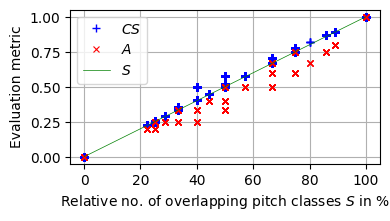

In [ ]:
relative_overlapping_plot(pairwise_stats)

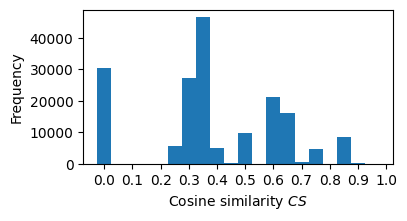

In [ ]:
cossim_plot(pairwise_stats)

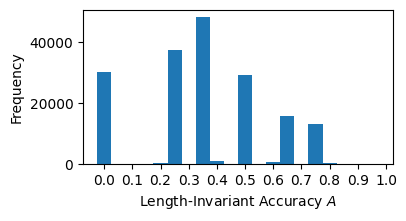

In [ ]:
lenInvar_plot(pairwise_stats)

## Madmom

In [ ]:
algorithm = 'Madmom'
previousstring = ''
counter = 0
allpairs = 0
pairwise_stats2 = np.zeros((0, 5))   # statistics: #pcs1, #pcs2, #pcsshared, cs, idm

for index, row in df_all_songs_ACE.iterrows():

        allpairs += 1
        exec("label1 = row['Reference']")
        exec("label2 = row[algorithm]")
        root1, shorthand1, scaledeg1, bass1 = mir_eval.chord.split(label1)
        root2, shorthand2, scaledeg2, bass2 = mir_eval.chord.split(label2)

        rootlist_clean = [root1, root2]
        while 'N' in rootlist_clean: rootlist_clean.remove('N')
        rootlist_clean = [mir_eval.chord.pitch_class_to_semitone(r) for r in rootlist_clean]

        if (len(rootlist_clean)>1):

            if (rootlist_clean[0]!=rootlist_clean[1]):
                counter+=1
                comparestring = root1+':'+shorthand1+' - '+root2+':'+shorthand2

                rootnum1, bitmap1, bassnum1 = mir_eval.chord.encode(label1, reduce_extended_chords=False, strict_bass_intervals=False)
                absolute_pcs1 = mir_eval.chord.rotate_bitmap_to_root(bitmap1, rootnum1)
                rootnum2, bitmap2, bassnum2 = mir_eval.chord.encode(label2, reduce_extended_chords=False, strict_bass_intervals=False)
                absolute_pcs2 = mir_eval.chord.rotate_bitmap_to_root(bitmap2, rootnum2)

                # cosine similarity measure
                cs12 = cossim(np.expand_dims(absolute_pcs1, axis=-1), np.expand_dims(absolute_pcs2, axis=-1))

                # insertion-deletion measure (Johanna)
                idm12 = predictionsInsertionsSymmetric(absolute_pcs1, absolute_pcs2)

                # if cs12>0.95:
                #print('{:<20}'.format(comparestring) + '   |  CS: ' + '{:.3f}'.format(cs12) + '  | IDM: ' + '{:.3f}'.format(idm12))

                pclist1 = set(absolute_pcs1.nonzero()[0])
                pclist2 = set(absolute_pcs2.nonzero()[0])
                pclistjoint = pclist1.intersection(pclist2)

                num_pcs1 = len(pclist1)
                num_pcs2 = len(pclist2)
                num_pcs_shared = len(pclistjoint)
                curr_stats = np.array([[num_pcs1, num_pcs2, num_pcs_shared, cs12, idm12]])
                pairwise_stats2 = np.concatenate((pairwise_stats2, curr_stats), axis=0)

                previousstring = comparestring

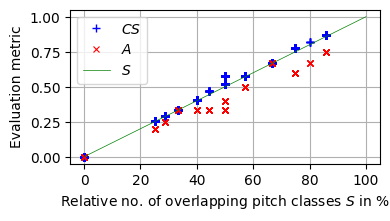

In [ ]:
relative_overlapping_plot(pairwise_stats2)

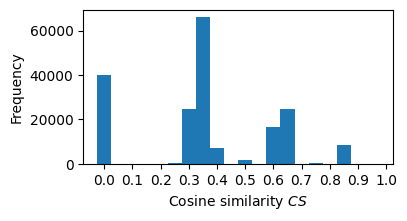

In [ ]:
cossim_plot(pairwise_stats2)

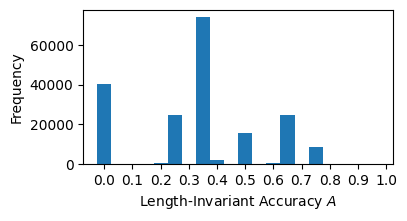

In [ ]:
lenInvar_plot(pairwise_stats2)